In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing and Importing libraries

In [3]:
!pip install ultralytics==8.0.114

!pip install opencv-python==4.7.0.72
!pip install supervision==0.1.0

!pip install easyocr




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 16.6 MB/s eta 0:00:00


In [4]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.114 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.0/107.7 GB disk)


In [5]:
from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [6]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [7]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [8]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [9]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [10]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Importing Models and Paths

In [11]:
from ultralytics import YOLO
license_plate_detector = YOLO('/content/drive/MyDrive/CIS_IEEE/best.pt' )
coco_model = YOLO('yolov8n.pt')


WARNING ⚠️ /content/drive/MyDrive/CIS_IEEE/best.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement "omegaconf" not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=986a13c3b6938788108f499fd10bfd26a841647ca5739ba390beb175fc43cf94
  Stored in directory: /tmp/pip-ephem-wheel-cache-kn41uvz_/wheels/12/93/dd/1f6a127edc4

In [31]:
SOURCE_VIDEO_PATH="/content/drive/MyDrive/CIS_IEEE/Traffic IP Camera video.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/CIS_IEEE/new.mp4"
FINAL_VIDEO_PATH = "/content/drive/MyDrive/CIS_IEEE/Final.mp4"

## Utility

In [28]:
import string
dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5'}

dict_int_to_char = {'0': 'O',
                    '1': 'I',
                    '3': 'J',
                    '4': 'A',
                    '6': 'G',
                    '5': 'S'}
def license_format(text):

  if len(text)!=10:
    return False
  if ((text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys()) and \
      (text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()) and \
      (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[2] in dict_char_to_int.keys()) and\
      (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[3] in dict_char_to_int.keys()) and \
      (text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()) and \
      (text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()) and \
      (text[6] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[6] in dict_char_to_int.keys()) and\
      (text[7] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[7] in dict_char_to_int.keys()) and \
      (text[8] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[8] in dict_char_to_int.keys()) and\
      (text[9] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[9] in dict_char_to_int.keys())):
    return True
  return False
def format_license(text):
    license_plate_ = ''
    mapping = {0: dict_int_to_char, 1: dict_int_to_char,2: dict_char_to_int, 3: dict_char_to_int, 4: dict_int_to_char, 5: dict_int_to_char, 6: dict_char_to_int,
                7:dict_char_to_int,8:dict_char_to_int,9:dict_char_to_int}
    for j in [0, 1, 2, 3, 4, 5, 6,7,8,9]:
        if text[j] in mapping[j].keys():
            license_plate_ += mapping[j][text[j]]
        else:
            license_plate_ += text[j]

    return license_plate_
def clean_license(text):
  text = text.upper().replace(' ', '')
  if license_format(text):
            return format_license(text)




In [22]:
def crop_image(image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    xyxy = np.round(xyxy).astype(int)
    x1, y1, x2, y2 = xyxy
    cropped_img = image[y1:y2, x1:x2]
    return cropped_img

# Infrence

In [13]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = coco_model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

In [19]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=30, total_frames=419)

In [20]:
import easyocr
reader=easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [21]:
LINE_START = Point(50, 800)
LINE_END = Point(3650, 800)



0: 384x640 1 person, 2 bicycles, 147.0ms
Speed: 4.7ms preprocess, 147.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 (no detections), 1198.0ms
Speed: 3.6ms preprocess, 1198.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x512 (no detections), 1391.6ms
Speed: 3.1ms preprocess, 1391.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x320 (no detections), 1503.6ms
Speed: 5.0ms preprocess, 1503.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


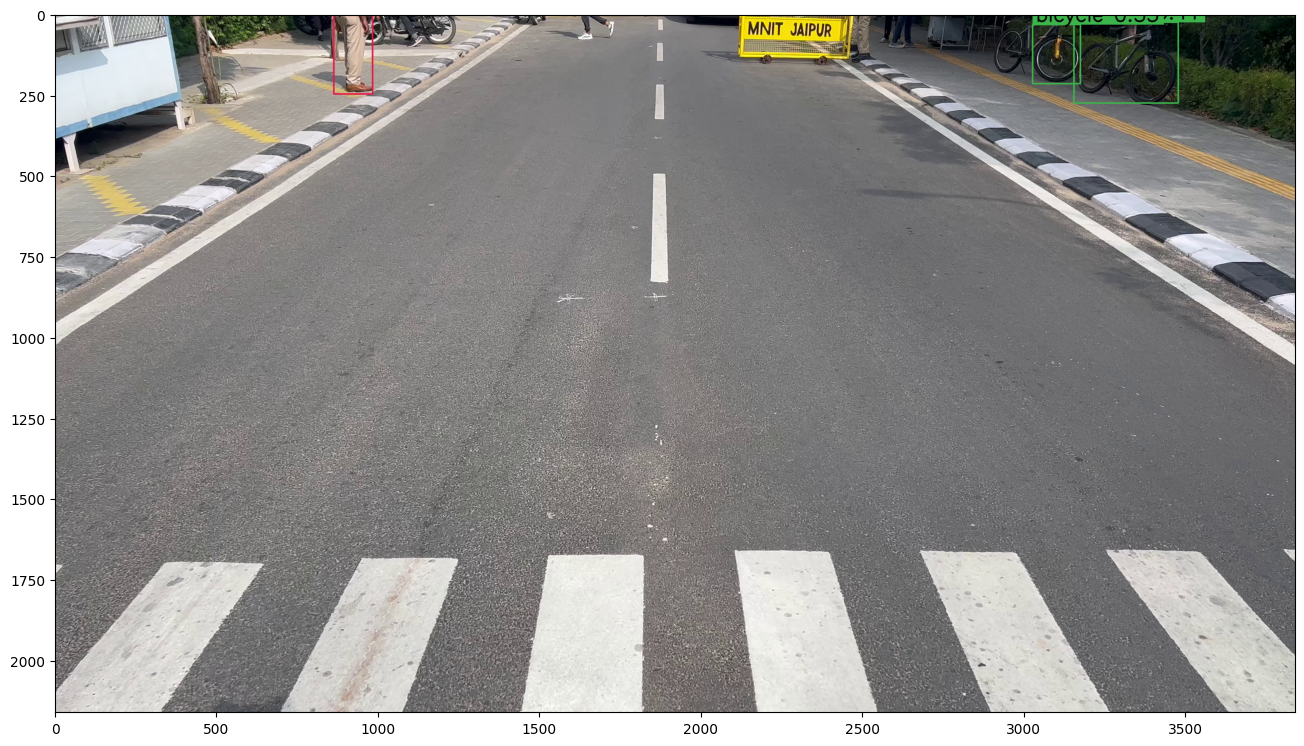

In [75]:

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = coco_model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
for xyxy in detections.xyxy:
  cropped_frame = crop_image(image=frame, xyxy=xyxy)
  results2=license_plate_detector(cropped_frame)
  detections2 = Detections(
  xyxy=results2[0].boxes.xyxy.cpu().numpy(),
  confidence=results2[0].boxes.conf.cpu().numpy(),
  class_id=results2[0].boxes.cls.cpu().numpy().astype(int)
        )
  for xyxy2 in detections2.xyxy:
    cropped_frame2 = crop_image(image=cropped_frame, xyxy=xyxy2)






# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)


%matplotlib inline
show_frame_in_notebook(frame, (16, 16))





In [ ]:
for detection in detections.xyxy:
  print(detection)

[     248.45      230.26      525.79      477.78]
[     414.37      153.87      642.44      362.72]
[     232.51      76.307      293.42      249.63]
[     649.12      46.108       668.4      71.469]


In [ ]:

from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow
import cv2
import datetime




byte_tracker = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

line_counter = LineCounter(start=LINE_START, end=LINE_END)

box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
in_time=[]
out_time=[]
arr=[]

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    for frame in tqdm(generator, total=video_info.total_frames):


        results = coco_model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )

        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)

        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)

        detections.tracker_id = np.array(tracker_id)

        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)





        for xyxy in detections.xyxy:
          cropped_frame = crop_image(image=frame, xyxy=xyxy)
          results2=license_plate_detector(cropped_frame)
          detections2 = Detections(
          xyxy=results2[0].boxes.xyxy.cpu().numpy(),
          confidence=results2[0].boxes.conf.cpu().numpy(),
          class_id=results2[0].boxes.cls.cpu().numpy().astype(int)
        )

          # for xyxy2 in detections2.xyxy:
          #   cropped_frame2 = crop_image(image=cropped_frame, xyxy=xyxy2)
          #   res = reader.readtext(cropped_frame2)
          #   for i in range(len(res)):
          #     ans=clean_license(res[i][1])


          #     if ans not in arr :
          #       arr.append(ans)
          #       show_frame_in_notebook(cropped_frame2, (16, 16))





        line_counter.update(detections=detections)

        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]



        line_counter.update(detections=detections)

        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/749 [00:00<?, ?it/s]


0: 384x640 1 person, 3 cars, 226.8ms
Speed: 3.2ms preprocess, 226.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 1 licence, 5002.8ms
Speed: 4.3ms preprocess, 5002.8ms inference, 15.3ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 (no detections), 4112.4ms
Speed: 15.9ms preprocess, 4112.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 3 cars, 164.1ms
Speed: 3.7ms preprocess, 164.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 1 licence, 1421.2ms
Speed: 5.0ms preprocess, 1421.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 (no detections), 1514.8ms
Speed: 10.9ms preprocess, 1514.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 person, 3 cars, 155.5ms
Speed: 3.0ms preprocess, 155.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 1 licence, 1415.5ms
Speed: 5.0ms preproce

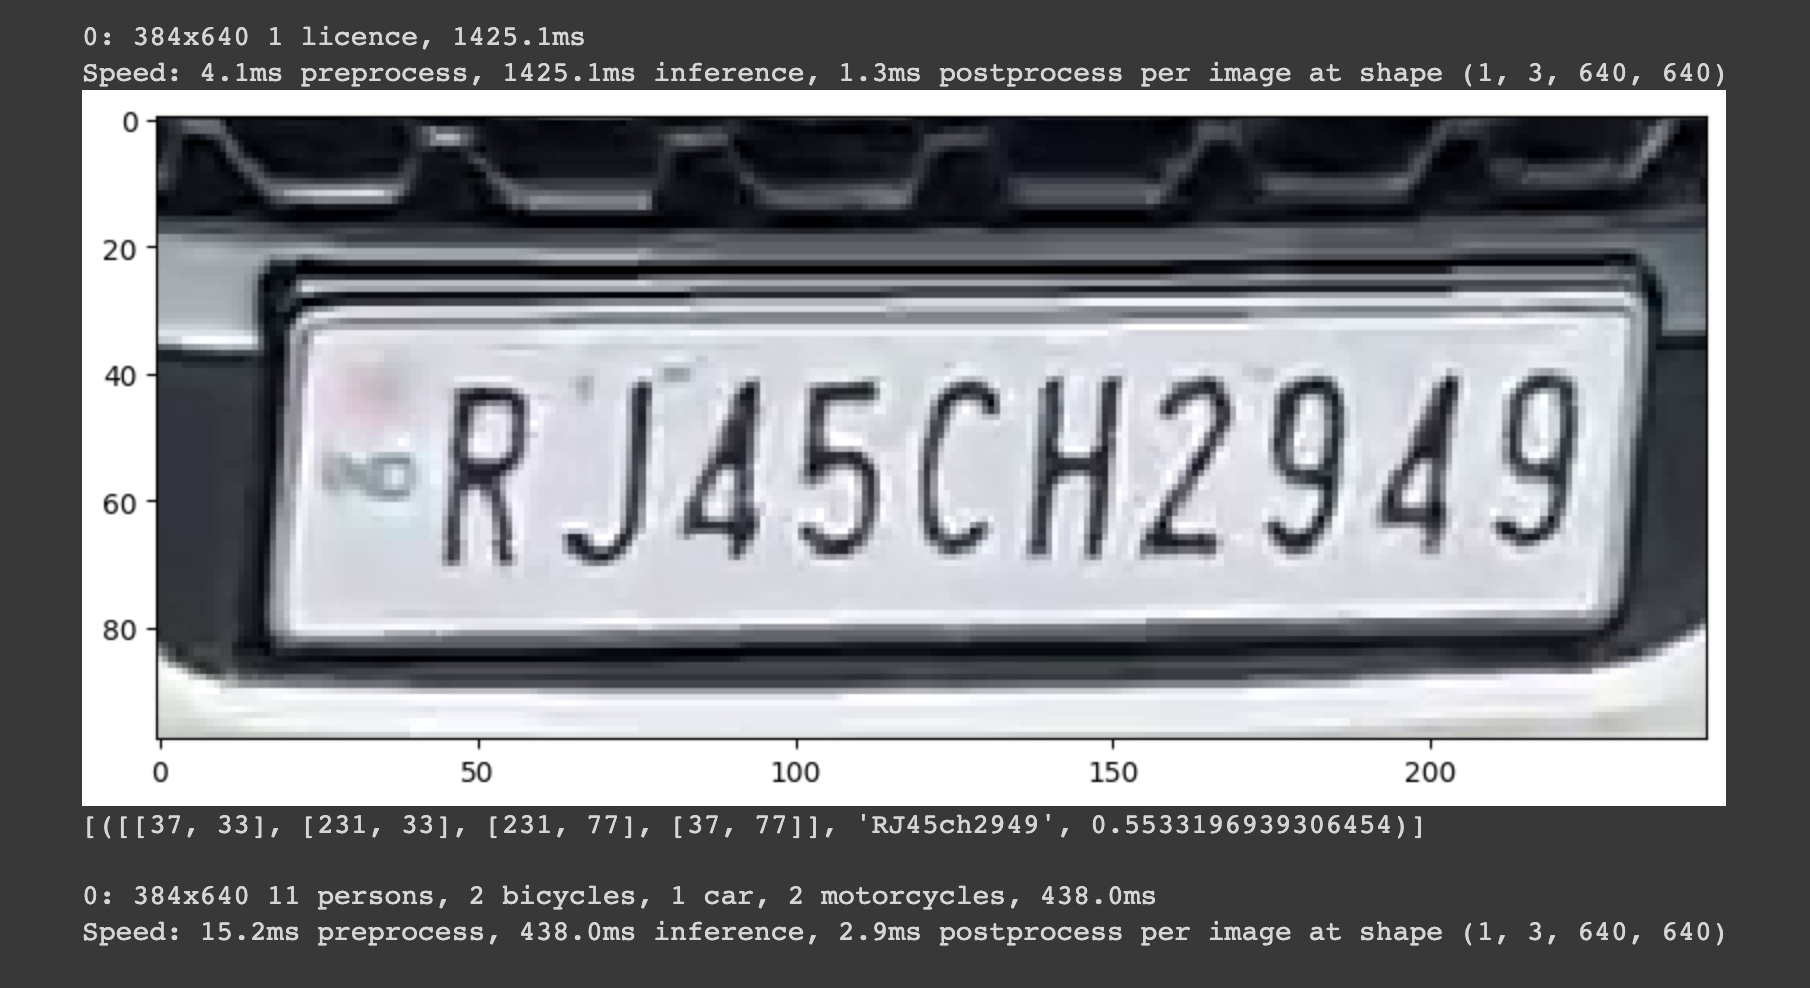

In [30]:
s=clean_license("RJ45ch2949")
print(s)

RJ45CH2949
